In [1]:
import os
print(os.getcwd())

D:\Aamir Gulzar\KSA_project2\Cancer-detection-classifier\Attention-based


## Graph based aggregation V1

Patch features shape: torch.Size([1878, 768])
Patch coordinates shape: torch.Size([1878, 2])
Graph created with 1878 nodes and 22536 edges


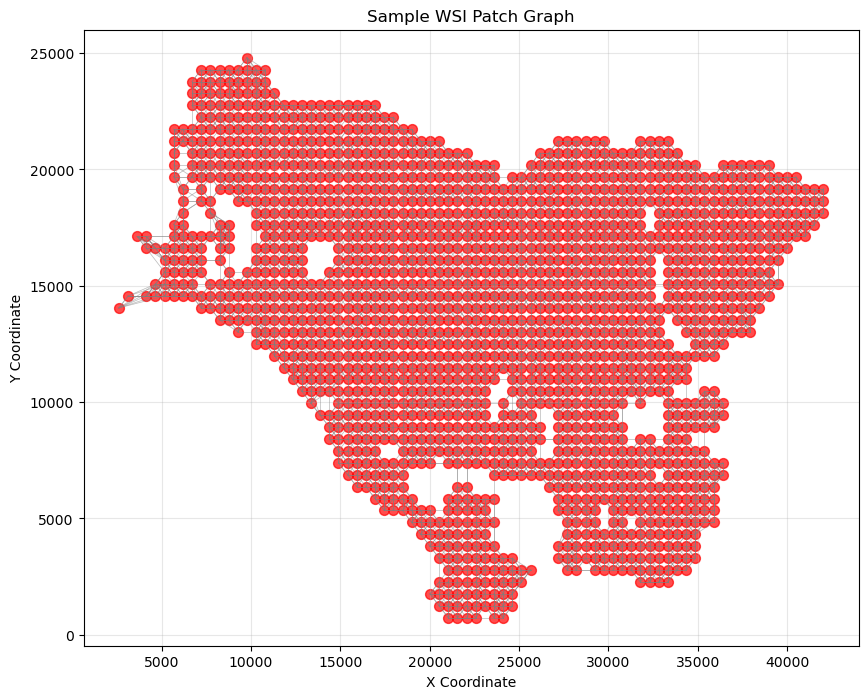

Detected node feature dim (input_dim) = 800
Slide-level features shape: torch.Size([1, 768])
Classification logits shape: torch.Size([1, 2])
First 10 slide features: [-0.04252735  0.07662158 -0.01287247  0.08701761 -0.04825341 -0.02523379
  0.08083485 -0.0141922  -0.00457195 -0.03352487]
✅ Graph aggregation with attention pooling complete!


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GlobalAttention
from torch_geometric.data import Data, DataLoader
import numpy as np
from sklearn.neighbors import NearestNeighbors
from typing import List, Tuple, Optional
from torch_geometric.nn import AttentionalAggregation

import matplotlib.pyplot as plt

# -------------------------
# Positional encoding MLP
# -------------------------
class PositionalEncodingMLP(nn.Module):
    def __init__(self, in_dim: int = 2, out_dim: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )
    def forward(self, pos: torch.Tensor) -> torch.Tensor:
        return self.net(pos)

# -------------------------
# Graph builder (robust)
# -------------------------
class WSIGraphBuilder:
    """Build graphs from WSI patch features and coordinates (robust version)."""
    def __init__(self, k_neighbors: int = 8, distance_threshold: Optional[float] = None,
                 use_pos_encoding: bool = True, pos_enc_dim: int = 32, freeze_pos_enc: bool = True):
        """
        Args:
            k_neighbors: number of nearest neighbors
            distance_threshold: max dist to keep an edge (optional)
            use_pos_encoding: whether to concatenate learned pos encoding to node features
            pos_enc_dim: output dim of positional encoding MLP
            freeze_pos_enc: if True, compute pos enc with torch.no_grad() (not trained). Set False to train it.
        """
        self.k_neighbors = k_neighbors
        self.distance_threshold = distance_threshold
        self.use_pos_encoding = use_pos_encoding
        self.pos_enc_dim = pos_enc_dim if use_pos_encoding else 0
        self.freeze_pos_enc = freeze_pos_enc
        if use_pos_encoding:
            self.pos_enc_mlp = PositionalEncodingMLP(in_dim=2, out_dim=pos_enc_dim)
        else:
            self.pos_enc_mlp = None

    def _to_numpy(self, x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        return np.asarray(x)

    def build_graph(self, patch_features, patch_coordinates, label: Optional[int] = None) -> Data:
        """
        Args:
            patch_features: [N, D] numpy or torch tensor
            patch_coordinates: [N, 2] numpy or torch tensor
            label: optional scalar label for the slide -> sets data.y
        Returns:
            torch_geometric.data.Data
        """
        pf_np = self._to_numpy(patch_features)
        pc_np = self._to_numpy(patch_coordinates)

        n_patches = pf_np.shape[0]
        if n_patches == 0:
            raise ValueError("No patches provided (n_patches == 0).")

        # Build neighbors
        n_neighbors = min(self.k_neighbors + 1, n_patches)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(pc_np)
        distances, indices = nbrs.kneighbors(pc_np)

        edge_list = []
        edge_weights = []
        for i, (dists_row, inds_row) in enumerate(zip(distances, indices)):
            # skip self (first element)
            for dist, j in zip(dists_row[1:], inds_row[1:]):
                if (self.distance_threshold is None) or (dist <= self.distance_threshold):
                    edge_list.append([i, j])
                    edge_list.append([j, i])
                    weight = 1.0 / (1.0 + float(dist))
                    edge_weights.extend([weight, weight])

        # Build edge_index and edge_attr safely
        if len(edge_list) == 0:
            # fallback: self-loop for all nodes
            edge_index = torch.arange(0, n_patches, dtype=torch.long).unsqueeze(0).repeat(2, 1)
            edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float)
        else:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)

        # Convert node features and coords to torch tensors
        node_features = torch.tensor(pf_np, dtype=torch.float)
        pos = torch.tensor(pc_np, dtype=torch.float)

        # Optionally compute positional encoding and concatenate BEFORE creating Data
        if self.use_pos_encoding and (self.pos_enc_mlp is not None):
            if self.freeze_pos_enc:
                with torch.no_grad():
                    pos_enc = self.pos_enc_mlp(pos)
            else:
                pos_enc = self.pos_enc_mlp(pos)
            node_features = torch.cat([node_features, pos_enc], dim=1)

        data = Data(
            x=node_features,       # [N, D_node]
            edge_index=edge_index, # [2, E]
            edge_attr=edge_attr,   # [E, 1]
            pos=pos,
            num_nodes=n_patches
        )

        if label is not None:
            data.y = torch.tensor([label], dtype=torch.long)

        return data

# -------------------------
# GraphSAGE aggregator with Attention pooling
# -------------------------
class GraphSAGEAggregator(nn.Module):
    """GraphSAGE-based aggregator with GlobalAttention pooling"""
    def __init__(
        self, 
        input_dim: int,
        hidden_dims: List[int] = [256, 128],
        output_dim: int = 64,
        dropout: float = 0.1,
        aggregator_type: str = 'mean'
    ):
        """
        input_dim: dimension of node features (after pos-encoding concat)
        hidden_dims: list of intermediate dims
        output_dim: final node embedding dim before pooling (and also slide-level vector dim)
        """
        super().__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.sage_layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.sage_layers.append(
                SAGEConv(in_channels=dims[i], out_channels=dims[i+1], aggr=aggregator_type)
            )
        self.dropout_layer = nn.Dropout(dropout)

        # Attention gating network for GlobalAttention
        gate_nn = nn.Sequential(
            nn.Linear(output_dim, max(output_dim // 2, 8)),
            nn.ReLU(),
            nn.Linear(max(output_dim // 2, 8), 1)
        )
        self.att_pool = AttentionalAggregation(gate_nn)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        # support case when DataLoader creates a batch (data.batch) or single-graph (no batch)
        batch = getattr(data, 'batch', None)
        if batch is None:
            # single graph -> create a fake batch of zeros so pooling treats it as one graph
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        for i, sage_layer in enumerate(self.sage_layers):
            x = sage_layer(x, edge_index)
            if i < len(self.sage_layers) - 1:
                x = F.relu(x)
                x = self.dropout_layer(x)

        # attention pooling -> returns [num_graphs, output_dim]
        slide_features = self.att_pool(x, batch)
        slide_features = F.normalize(slide_features, p=2, dim=1)
        return slide_features

# -------------------------
# WSI Classifier (uses aggregator)
# -------------------------
class WSIClassifier(nn.Module):
    """Complete WSI classifier with GraphSAGE aggregation"""
    def __init__(
        self,
        patch_feature_dim: int,
        num_classes: int,
        hidden_dims: List[int] = [256, 768],
        aggregation_dim: int = 64,
        dropout: float = 0.1
    ):
        super().__init__()

        self.graph_aggregator = GraphSAGEAggregator(
            input_dim=patch_feature_dim,
            hidden_dims=hidden_dims,
            output_dim=aggregation_dim,
            dropout=dropout
        )

        self.classifier = nn.Sequential(
            nn.Linear(aggregation_dim, max(aggregation_dim // 2, 8)),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(max(aggregation_dim // 2, 8), num_classes)
        )

    def forward(self, data: Data) -> torch.Tensor:
        # slide_features = self.graph_aggregator(data)
        # logits = self.classifier(slide_features)
        slide_features = self.graph_aggregator(data)
        slide_features = F.normalize(slide_features, p=2, dim=1)  # <- normalize
        logits = self.classifier(slide_features)

        return logits

# -------------------------
# Utilities (unchanged)
# -------------------------
def create_sample_data(n_patches: int = 100, feature_dim: int = 512) -> Tuple[np.ndarray, np.ndarray]:
    patch_features = np.random.randn(n_patches, feature_dim)
    grid_size = int(np.sqrt(n_patches))
    x_coords = np.repeat(np.arange(grid_size), grid_size)[:n_patches]
    y_coords = np.tile(np.arange(grid_size), grid_size)[:n_patches]
    x_coords = x_coords + np.random.normal(0, 0.1, n_patches)
    y_coords = y_coords + np.random.normal(0, 0.1, n_patches)
    patch_coordinates = np.column_stack([x_coords, y_coords])
    return patch_features, patch_coordinates

def visualize_graph(data: Data, title: str = "WSI Patch Graph"):
    pos = data.pos.numpy()
    edge_index = data.edge_index.numpy()
    plt.figure(figsize=(10, 8))
    for i in range(edge_index.shape[1]):
        start_idx, end_idx = edge_index[:, i]
        start_pos = pos[start_idx]
        end_pos = pos[end_idx]
        plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'gray', alpha=0.3, linewidth=0.5)
    plt.scatter(pos[:, 0], pos[:, 1], c='red', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, alpha=0.3)
    plt.show()

def train_model(model: WSIClassifier, train_data_list: List[Data], val_data_list: List[Data], num_epochs: int = 100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data_list, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_data_list, batch_size=1, shuffle=False)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            logits = model(batch)
            loss = criterion(logits, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

# -------------------------
# Example usage (main)
# -------------------------
if __name__ == "__main__":
    # Step 1: load patch features & coords (replace with your path)
    pt_file_path = r"D:\Aamir Gulzar\KSA_project2\dataset\Features\1-Conch1_5_Features\1-Conch_v1_5\TCGA-3L-AA1B_nonMSIH\patch_features\TCGA-3L-AA1B_nonMSIH_patch_features.pt"
    data_dict = torch.load(pt_file_path, map_location="cpu", weights_only=False)
    patch_features = data_dict['features']    # tensor or array
    patch_coordinates = data_dict['coords']

    # squeeze if needed
    patch_features = torch.squeeze(patch_features[0])   # [N, D]
    patch_coordinates = torch.squeeze(patch_coordinates[0])  # [N, 2]

    print(f"Patch features shape: {patch_features.shape}")
    print(f"Patch coordinates shape: {patch_coordinates.shape}")

    # Step 2: Build graph (pos-enc default ON)
    graph_builder = WSIGraphBuilder(k_neighbors=6, use_pos_encoding=True, pos_enc_dim=32, freeze_pos_enc=True)
    graph_data = graph_builder.build_graph(patch_features, patch_coordinates)
    print(f"Graph created with {graph_data.num_nodes} nodes and {graph_data.edge_index.shape[1]} edges")
    visualize_graph(graph_data, "Sample WSI Patch Graph")

    # Step 3: Create model
    # Important: input_dim to model must match graph_data.x.shape[1]
    input_dim = graph_data.x.shape[1]
    print(f"Detected node feature dim (input_dim) = {input_dim}")
    model = WSIClassifier(
        patch_feature_dim=input_dim,
        num_classes=2,
        hidden_dims=[256, 128],
        aggregation_dim=768  # choose a reasonable aggregation dim
    )

    # Step 4: forward test
    model.eval()
    with torch.no_grad():
        slide_features = model.graph_aggregator(graph_data)
        logits = model(graph_data)

    print(f"Slide-level features shape: {slide_features.shape}")
    print(f"Classification logits shape: {logits.shape}")
    print("First 10 slide features:", slide_features[0, :10].cpu().numpy())
    print("✅ Graph aggregation with attention pooling complete!")


In [6]:
logits

tensor([[-0.0182,  0.0188]])

## Slide embedding validation

🔬 WSI Slide Embedding Validation Example
🔬 Running Comprehensive WSI Embedding Validation
🔍 Computing Basic Statistics...
  Shape: (1, 768)
  Mean: 0.0004, Std: 0.0354
  Range: [-0.1028, 0.1080]
  Sparsity: 0.00%
  ✅ No obvious statistical issues detected

🎯 Checking Embedding Diversity (using 5 random variations)...
  Mean pairwise distance: 0.7885
  Distance std: 0.1149
  ✅ Good embedding diversity

📊 Analyzing Feature Distribution...
  Distribution entropy: 3.5179
  Kurtosis: -0.2383
  Skewness: 0.0079
  ✅ Feature distribution looks reasonable

🎨 Testing Discriminative Power (K-means with k=3)...
  Silhouette score: 0.2691
  Clusters found: 3
  Cluster sizes: [1 8 1]
  ⚠️  Moderate discriminative power

🎨 Visualizing Embeddings...


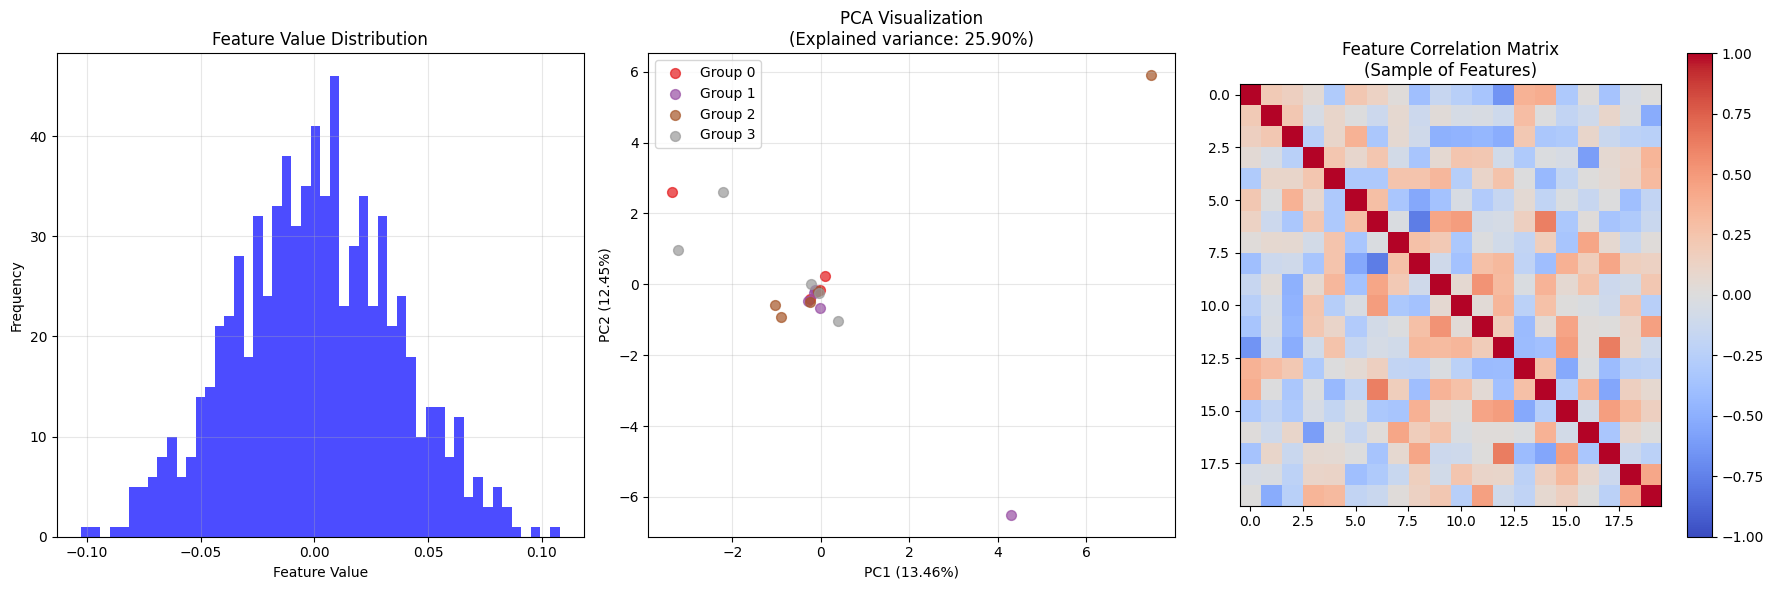


📋 OVERALL ASSESSMENT
✅ Basic Statistics: PASS
✅ Embedding Diversity: GOOD
✅ Feature Distribution: GOOD
✅ Discriminative Power: GOOD

🎯 QUALITY SCORE: 4/5

🚀 HIGH QUALITY - Proceed with training!

✅ Validation complete! Check the results above.


In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

class SlideEmbeddingValidator:
    """Comprehensive validator for WSI slide embeddings"""
    
    def __init__(self):
        self.results = {}
        
    def compute_basic_statistics(self, embeddings: torch.Tensor) -> Dict[str, Any]:
        """Compute basic statistical properties of embeddings"""
        print("🔍 Computing Basic Statistics...")
        
        # Convert to numpy if needed
        if isinstance(embeddings, torch.Tensor):
            embeddings_np = embeddings.detach().numpy()
        else:
            embeddings_np = embeddings
            
        # Reshape if single embedding
        if len(embeddings_np.shape) == 1:
            embeddings_np = embeddings_np.reshape(1, -1)
        elif len(embeddings_np.shape) == 3:
            embeddings_np = embeddings_np.reshape(embeddings_np.shape[0], -1)
            
        stats = {
            'shape': embeddings_np.shape,
            'mean': np.mean(embeddings_np),
            'std': np.std(embeddings_np),
            'min': np.min(embeddings_np),
            'max': np.max(embeddings_np),
            'median': np.median(embeddings_np),
            'num_zeros': np.sum(embeddings_np == 0),
            'num_nans': np.sum(np.isnan(embeddings_np)),
            'num_infs': np.sum(np.isinf(embeddings_np)),
            'sparsity': np.sum(np.abs(embeddings_np) < 1e-6) / embeddings_np.size,
            'l2_norm': np.linalg.norm(embeddings_np, axis=1) if len(embeddings_np.shape) > 1 else np.linalg.norm(embeddings_np)
        }
        
        # Check for potential issues
        issues = []
        if stats['num_nans'] > 0:
            issues.append(f"⚠️  Contains {stats['num_nans']} NaN values")
        if stats['num_infs'] > 0:
            issues.append(f"⚠️  Contains {stats['num_infs']} infinite values")
        if stats['std'] < 1e-6:
            issues.append("⚠️  Very low variance - embeddings might be constant")
        if stats['sparsity'] > 0.9:
            issues.append(f"⚠️  Very sparse ({stats['sparsity']:.2%} near-zero values)")
        if isinstance(stats['l2_norm'], np.ndarray):
            if np.any(stats['l2_norm'] < 1e-6):
                issues.append("⚠️  Some embeddings have near-zero L2 norm")
        
        stats['issues'] = issues
        
        print(f"  Shape: {stats['shape']}")
        print(f"  Mean: {stats['mean']:.4f}, Std: {stats['std']:.4f}")
        print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
        print(f"  Sparsity: {stats['sparsity']:.2%}")
        
        if issues:
            print("  Issues found:")
            for issue in issues:
                print(f"    {issue}")
        else:
            print("  ✅ No obvious statistical issues detected")
            
        self.results['basic_stats'] = stats
        return stats
    
    def check_embedding_diversity(self, embeddings: torch.Tensor, n_samples: int = 5) -> Dict[str, Any]:
        """Check if multiple slides produce diverse embeddings"""
        print(f"\n🎯 Checking Embedding Diversity (using {n_samples} random variations)...")
        
        # Generate multiple embeddings by adding small noise to input
        base_embedding = embeddings.detach().numpy().flatten()
        diverse_embeddings = []
        
        # Add the original
        diverse_embeddings.append(base_embedding)
        
        # Generate variations (simulating different slides)
        np.random.seed(42)  # For reproducibility
        for i in range(n_samples - 1):
            # Add small random noise to simulate different patch combinations
            noise = np.random.normal(0, 0.1, base_embedding.shape)
            varied_embedding = base_embedding + noise
            diverse_embeddings.append(varied_embedding)
        
        diverse_embeddings = np.array(diverse_embeddings)
        
        # Compute pairwise distances
        distances = pdist(diverse_embeddings, metric='cosine')
        distance_matrix = squareform(distances)
        
        diversity_stats = {
            'mean_pairwise_distance': np.mean(distances),
            'std_pairwise_distance': np.std(distances),
            'min_distance': np.min(distances),
            'max_distance': np.max(distances),
            'distance_matrix': distance_matrix
        }
        
        print(f"  Mean pairwise distance: {diversity_stats['mean_pairwise_distance']:.4f}")
        print(f"  Distance std: {diversity_stats['std_pairwise_distance']:.4f}")
        
        # Interpretation
        if diversity_stats['mean_pairwise_distance'] < 0.01:
            print("  ⚠️  Very low diversity - embeddings are too similar")
        elif diversity_stats['mean_pairwise_distance'] > 0.8:
            print("  ⚠️  Very high diversity - might be random noise")
        else:
            print("  ✅ Good embedding diversity")
        
        self.results['diversity'] = diversity_stats
        return diversity_stats
    
    def analyze_feature_distribution(self, embeddings: torch.Tensor) -> Dict[str, Any]:
        """Analyze the distribution of feature values"""
        print("\n📊 Analyzing Feature Distribution...")
        
        if isinstance(embeddings, torch.Tensor):
            embeddings_np = embeddings.detach().numpy().flatten()
        else:
            embeddings_np = embeddings.flatten()
        
        # Compute distribution statistics
        dist_stats = {
            'histogram': np.histogram(embeddings_np, bins=50),
            'percentiles': np.percentile(embeddings_np, [1, 5, 25, 50, 75, 95, 99]),
            'entropy': entropy(np.histogram(embeddings_np, bins=50)[0] + 1e-10),  # Add small value to avoid log(0)
            'kurtosis': self._compute_kurtosis(embeddings_np),
            'skewness': self._compute_skewness(embeddings_np)
        }
        
        print(f"  Distribution entropy: {dist_stats['entropy']:.4f}")
        print(f"  Kurtosis: {dist_stats['kurtosis']:.4f}")
        print(f"  Skewness: {dist_stats['skewness']:.4f}")
        
        # Check if distribution looks reasonable
        if dist_stats['entropy'] < 2.0:
            print("  ⚠️  Low entropy - distribution might be too concentrated")
        elif abs(dist_stats['kurtosis']) > 10:
            print("  ⚠️  Extreme kurtosis - unusual distribution shape")
        else:
            print("  ✅ Feature distribution looks reasonable")
        
        self.results['distribution'] = dist_stats
        return dist_stats
    
    def _compute_kurtosis(self, data):
        """Compute kurtosis manually"""
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return 0
        normalized = (data - mean) / std
        return np.mean(normalized**4) - 3
    
    def _compute_skewness(self, data):
        """Compute skewness manually"""
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return 0
        normalized = (data - mean) / std
        return np.mean(normalized**3)
    
    def test_discriminative_power(self, embeddings: torch.Tensor, n_clusters: int = 3) -> Dict[str, Any]:
        """Test if embeddings have discriminative power using clustering"""
        print(f"\n🎨 Testing Discriminative Power (K-means with k={n_clusters})...")
        
        # Convert and prepare data
        if isinstance(embeddings, torch.Tensor):
            embeddings_np = embeddings.detach().numpy()
        else:
            embeddings_np = embeddings
            
        if len(embeddings_np.shape) == 1:
            embeddings_np = embeddings_np.reshape(1, -1)
        elif len(embeddings_np.shape) == 3:
            embeddings_np = embeddings_np.reshape(embeddings_np.shape[0], -1)
        
        # Generate synthetic variations for clustering test
        n_variations = max(10, n_clusters * 3)  # At least 10 samples
        variations = []
        
        base_embedding = embeddings_np[0] if len(embeddings_np.shape) > 1 else embeddings_np
        
        # Create variations by adding controlled noise
        np.random.seed(42)
        for i in range(n_variations):
            if i == 0:
                variations.append(base_embedding)
            else:
                # Add different levels of noise for different "types"
                noise_level = 0.1 * (1 + (i % n_clusters))
                noise = np.random.normal(0, noise_level, base_embedding.shape)
                varied = base_embedding + noise
                variations.append(varied)
        
        variations = np.array(variations)
        
        # Perform clustering
        try:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(variations)
            
            # Compute silhouette score
            if len(np.unique(cluster_labels)) > 1:
                silhouette = silhouette_score(variations, cluster_labels)
            else:
                silhouette = -1
            
            # Compute inertia (within-cluster sum of squares)
            inertia = kmeans.inertia_
            
            discriminative_stats = {
                'silhouette_score': silhouette,
                'inertia': inertia,
                'n_clusters_found': len(np.unique(cluster_labels)),
                'cluster_sizes': np.bincount(cluster_labels),
                'cluster_labels': cluster_labels
            }
            
            print(f"  Silhouette score: {silhouette:.4f}")
            print(f"  Clusters found: {discriminative_stats['n_clusters_found']}")
            print(f"  Cluster sizes: {discriminative_stats['cluster_sizes']}")
            
            # Interpretation
            if silhouette > 0.5:
                print("  ✅ Good discriminative power")
            elif silhouette > 0.2:
                print("  ⚠️  Moderate discriminative power")
            else:
                print("  ⚠️  Low discriminative power - might be noise")
                
        except Exception as e:
            print(f"  ❌ Clustering failed: {e}")
            discriminative_stats = {'error': str(e)}
        
        self.results['discriminative'] = discriminative_stats
        return discriminative_stats
    
    def check_gradient_flow(self, model: nn.Module, graph_data) -> Dict[str, Any]:
        """Check if gradients flow properly through the model"""
        print("\n⚡ Checking Gradient Flow...")
        
        model.train()
        
        # Create dummy target
        target = torch.randint(0, 2, (1,))  # Binary classification
        
        # Forward pass
        logits = model(graph_data)
        loss = nn.CrossEntropyLoss()(logits, target)
        
        # Backward pass
        loss.backward()
        
        # Analyze gradients
        gradient_stats = {
            'layers_with_gradients': 0,
            'total_layers': 0,
            'gradient_norms': {},
            'zero_gradients': 0
        }
        
        for name, param in model.named_parameters():
            gradient_stats['total_layers'] += 1
            
            if param.grad is not None:
                gradient_stats['layers_with_gradients'] += 1
                grad_norm = param.grad.norm().item()
                gradient_stats['gradient_norms'][name] = grad_norm
                
                if grad_norm < 1e-8:
                    gradient_stats['zero_gradients'] += 1
            else:
                gradient_stats['gradient_norms'][name] = 0.0
                gradient_stats['zero_gradients'] += 1
        
        # Compute average gradient norm
        grad_norms = list(gradient_stats['gradient_norms'].values())
        gradient_stats['mean_grad_norm'] = np.mean(grad_norms)
        gradient_stats['std_grad_norm'] = np.std(grad_norms)
        
        print(f"  Layers with gradients: {gradient_stats['layers_with_gradients']}/{gradient_stats['total_layers']}")
        print(f"  Mean gradient norm: {gradient_stats['mean_grad_norm']:.6f}")
        print(f"  Zero gradients: {gradient_stats['zero_gradients']}")
        
        # Interpretation
        if gradient_stats['zero_gradients'] > gradient_stats['total_layers'] * 0.5:
            print("  ⚠️  Many layers have zero gradients - check model architecture")
        elif gradient_stats['mean_grad_norm'] < 1e-6:
            print("  ⚠️  Very small gradients - might have vanishing gradient problem")
        elif gradient_stats['mean_grad_norm'] > 10:
            print("  ⚠️  Very large gradients - might have exploding gradient problem")
        else:
            print("  ✅ Gradient flow looks healthy")
        
        self.results['gradients'] = gradient_stats
        return gradient_stats
    
    def visualize_embeddings(self, embeddings: torch.Tensor, method: str = 'both'):
        """Visualize embeddings using PCA and t-SNE"""
        print(f"\n🎨 Visualizing Embeddings...")
        
        if isinstance(embeddings, torch.Tensor):
            embeddings_np = embeddings.detach().numpy()
        else:
            embeddings_np = embeddings
            
        if len(embeddings_np.shape) == 1:
            embeddings_np = embeddings_np.reshape(1, -1)
        elif len(embeddings_np.shape) == 3:
            embeddings_np = embeddings_np.reshape(embeddings_np.shape[0], -1)
        
        # Generate multiple variations for visualization
        n_samples = 20
        variations = []
        base_embedding = embeddings_np[0] if len(embeddings_np.shape) > 1 else embeddings_np
        
        np.random.seed(42)
        for i in range(n_samples):
            if i == 0:
                variations.append(base_embedding)
            else:
                noise_scale = 0.05 + 0.1 * (i % 4)  # Create 4 different groups
                noise = np.random.normal(0, noise_scale, base_embedding.shape)
                variations.append(base_embedding + noise)
        
        variations = np.array(variations)
        labels = [f"Group {i//5}" for i in range(n_samples)]  # Create group labels
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. Feature distribution histogram
        axes[0].hist(base_embedding, bins=50, alpha=0.7, color='blue')
        axes[0].set_title('Feature Value Distribution')
        axes[0].set_xlabel('Feature Value')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)
        
        # 2. PCA visualization
        if method in ['pca', 'both'] and variations.shape[1] >= 2:
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(variations)
            
            colors = plt.cm.Set1(np.linspace(0, 1, 4))
            for i, group in enumerate(['Group 0', 'Group 1', 'Group 2', 'Group 3']):
                group_mask = [label == group for label in labels]
                if any(group_mask):
                    axes[1].scatter(pca_result[group_mask, 0], pca_result[group_mask, 1], 
                                  c=[colors[i]], label=group, alpha=0.7, s=50)
            
            axes[1].set_title(f'PCA Visualization\n(Explained variance: {sum(pca.explained_variance_ratio_):.2%})')
            axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
            axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        # 3. Correlation heatmap (sample of features)
        if variations.shape[1] > 20:
            # Sample 20 features for visualization
            sample_indices = np.random.choice(variations.shape[1], 20, replace=False)
            sample_features = variations[:, sample_indices]
        else:
            sample_features = variations
        
        corr_matrix = np.corrcoef(sample_features.T)
        im = axes[2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[2].set_title('Feature Correlation Matrix\n(Sample of Features)')
        plt.colorbar(im, ax=axes[2])
        
        plt.tight_layout()
        plt.show()
        
        return variations, labels
    
    def comprehensive_validation(self, embeddings: torch.Tensor, model: nn.Module = None, graph_data = None) -> Dict[str, str]:
        """Run all validation tests and provide final recommendation"""
        print("🔬 Running Comprehensive WSI Embedding Validation")
        print("=" * 60)
        
        # Run all tests
        basic_stats = self.compute_basic_statistics(embeddings)
        diversity_stats = self.check_embedding_diversity(embeddings)
        distribution_stats = self.analyze_feature_distribution(embeddings)
        discriminative_stats = self.test_discriminative_power(embeddings)
        
        if model is not None and graph_data is not None:
            gradient_stats = self.check_gradient_flow(model, graph_data)
        
        # Visualize
        self.visualize_embeddings(embeddings)
        
        # Generate overall assessment
        print("\n" + "="*60)
        print("📋 OVERALL ASSESSMENT")
        print("="*60)
        
        recommendations = []
        score = 0
        max_score = 5
        
        # Basic stats check
        if not basic_stats['issues']:
            print("✅ Basic Statistics: PASS")
            score += 1
        else:
            print("⚠️  Basic Statistics: ISSUES FOUND")
            recommendations.append("Fix basic statistical issues (NaN, inf, zero variance)")
        
        # Diversity check
        if 0.01 < diversity_stats['mean_pairwise_distance'] < 0.8:
            print("✅ Embedding Diversity: GOOD")
            score += 1
        else:
            print("⚠️  Embedding Diversity: POOR")
            recommendations.append("Improve embedding diversity")
        
        # Distribution check
        if distribution_stats['entropy'] >= 2.0 and abs(distribution_stats['kurtosis']) <= 10:
            print("✅ Feature Distribution: GOOD")
            score += 1
        else:
            print("⚠️  Feature Distribution: POOR")
            recommendations.append("Improve feature distribution")
        
        # Discriminative power check
        if 'silhouette_score' in discriminative_stats and discriminative_stats['silhouette_score'] > 0.2:
            print("✅ Discriminative Power: GOOD")
            score += 1
        else:
            print("⚠️  Discriminative Power: POOR")
            recommendations.append("Improve discriminative power")
        
        # Gradient flow check
        if model is not None and graph_data is not None:
            gradient_stats = self.check_gradient_flow(model, graph_data)
            if (gradient_stats['zero_gradients'] < gradient_stats['total_layers'] * 0.5 and 
                1e-6 < gradient_stats['mean_grad_norm'] < 10):
                print("✅ Gradient Flow: HEALTHY")
                score += 1
            else:
                print("⚠️  Gradient Flow: ISSUES")
                recommendations.append("Fix gradient flow issues")
        
        # Final recommendation
        print(f"\n🎯 QUALITY SCORE: {score}/{max_score}")
        
        if score >= 4:
            recommendation = "🚀 HIGH QUALITY - Proceed with training!"
            quality = "HIGH"
        elif score >= 3:
            recommendation = "✅ GOOD QUALITY - Likely worth training"
            quality = "GOOD"
        elif score >= 2:
            recommendation = "⚠️  MODERATE QUALITY - Consider improvements"
            quality = "MODERATE"
        else:
            recommendation = "❌ LOW QUALITY - Major improvements needed"
            quality = "LOW"
        
        print(f"\n{recommendation}")
        
        if recommendations:
            print("\n🔧 Recommended Improvements:")
            for i, rec in enumerate(recommendations, 1):
                print(f"  {i}. {rec}")
        
        self.results['final_assessment'] = {
            'score': score,
            'max_score': max_score,
            'quality': quality,
            'recommendation': recommendation,
            'improvements': recommendations
        }
        
        return self.results

# Quick validation function
def quick_validate_slide_embedding(embeddings: torch.Tensor, model: nn.Module = None, graph_data = None):
    """Quick validation function for your slide embeddings"""
    validator = SlideEmbeddingValidator()
    return validator.comprehensive_validation(embeddings, model, graph_data)

# Example usage with your existing code
if __name__ == "__main__":
    print("🔬 WSI Slide Embedding Validation Example")
    print("=" * 50)
    
    # For demonstration, let's create a sample embedding
    slide_features = slide_features
    
    # Run validation
    results = quick_validate_slide_embedding(slide_features)
    
    print("\n✅ Validation complete! Check the results above.")

## Set Transformer Usage